## Modelo P1 usando **XGBoost**

Notebook con entrenamiento del modelo XGBoost con el dataframe con datos de peleas

Autor: Mateo Turati

Descripción: Obtengo los datos de train, validación y test, esta vez de forma aleatoria. Creo dos modelos de XGBoostClassifier usando dos métodos de ajuste de hiperparámetros y estudio sus resultados.

* [Carga de los datos](#carga-de-los-datos)
* [Modelo Baseline](#modelo-baseline)
* [Transformaciones](#transformaciones)
* [Selección de variables](#selección-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparámetros)
* [Conclusiones](#conclusiones)

In [ ]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow

### Descripción general del notebook

En este notebook realizaremos el modelado y entrenamiento de un modelo XGBoost para predecir el ganador de una pelea a partir de los datos disponibles.

En la fase de entrenamiento, buscaremos los hiperparámetros óptimos utilizando dos estrategias de ajuste. Primero, construiremos un modelo base (baseline), a partir del cual extraeremos conclusiones iniciales e intentaremos mejorarlo mediante dos técnicas de ajuste de hiperparámetros.

Para este ajuste, emplearemos las estrategias de búsqueda en rejilla (grid search) y búsqueda aleatoria (random search). Evaluaremos los modelos utilizando el F1-score con validación cruzada, dado que la variable de respuesta presenta un desbalance y queremos evitar que el modelo prediga predominantemente la clase mayoritaria.

El modelo con mejores resultados en la validación cruzada será seleccionado y analizaremos sus métricas en mayor profundidad.

El objetivo principal es obtener un modelo con una accuracy lo suficientemente alta para su posterior implementación en la fase de despliegue.

In [18]:
ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

# Configurar MLflow para guardar los modelos en esa ruta
mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

print("MLflow tracking URI:", mlflow.get_tracking_uri())  

MLflow tracking URI: file:///c:\Users\mattu\OneDrive\Documentos\GitHub\c2425-R4\mlruns


Guardamos los resultados de diferentes experimentos en la carpeta mlruns para comprobar diferentes modelos.

#### CARGA DE DATOS

Cargo los datos de train y test. Los cuales ya tenemos guardados en la carpeta data. Separamos en "X" e "y", guardando en "X" las variables que introduciremos en el modelo, eliminamos algunas variables que no aportan información sobre las peleas o variables que al realizar modelos observamos que tienen una importancia prácticamente nula. En la variable "y" guardamos la variable respuesta.

In [2]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..", "..", "data", "P1","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,Olivier Aubin-Mercier,Tony Sims,2015-08-23,LIGHTWEIGHT,False,Decision - Unanimous,300,3,0,0,...,2,0,1,0,0,0,0,0,1,1
1,Elvis Mutapcic,Anthony Smith,2016-12-03,MIDDLEWEIGHT,True,KO/TKO,207,2,0,1,...,0,0,1,1,1,0,0,1,1,1
2,Michael Johnson,Edward Faaloloto,2011-06-26,LIGHTWEIGHT,False,KO/TKO,282,1,1,0,...,0,0,0,0,0,1,0,0,1,0
3,Polyana Viana,Mallory Martin,2021-02-13,STRAWWEIGHT,False,Submission,198,1,0,0,...,3,1,0,0,0,0,1,2,2,0
4,Charles Jourdain,Nathaniel Wood,2022-09-03,FEATHERWEIGHT,True,Decision - Unanimous,300,3,0,0,...,1,3,1,3,0,1,1,0,5,1


In [3]:
ruta_test = os.path.join("..","..", "..","data", "P1","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,Peleador_A,Peleador_B,DATE,CATEGORY,WINNER,METHOD,TIME,ROUND,KD_A,KD_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
0,Steve Garcia,Kyle Nelson,2024-09-14,FEATHERWEIGHT,False,KO/TKO,239,1,0,0,...,0,0,0,3,1,3,0,1,1,1
1,Mac Danzig,Melvin Guillard,2013-07-27,LIGHTWEIGHT,True,KO/TKO,167,2,0,1,...,2,0,2,4,1,1,2,6,4,1
2,Darren Elkins,Chas Skelly,2016-03-05,FEATHERWEIGHT,False,Decision - Unanimous,300,3,0,0,...,0,2,8,1,1,0,1,0,2,2
3,Demian Maia,Rick Story,2012-10-13,WELTERWEIGHT,False,Submission,150,1,0,0,...,6,1,4,5,1,0,0,1,3,3
4,Nick Ring,James Head,2011-06-11,MIDDLEWEIGHT,False,Submission,213,3,0,1,...,1,0,1,0,0,0,0,1,0,0


In [14]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER","CATEGORY","METHOD","ROUND"])
y_train = df_train["WINNER"]
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))

WINNER
False    3444
True     2046
Name: count, dtype: int64
WINNER
False    0.627322
True     0.372678
Name: proportion, dtype: float64


In [15]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER","CATEGORY","METHOD","ROUND"])
y_test = df_test["WINNER"]
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

WINNER
False    1499
True      855
Name: count, dtype: int64
WINNER
False    0.636788
True     0.363212
Name: proportion, dtype: float64


Verificamos que los conjuntos tengan una proporción similar de la variable respuesta. Se ve un desequilibrio en la variable respuesta, debemos tener en cuenta que el peleador A suele ser el favorito.

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

Tan solo eliminamos algunas variables que vimos que tenían una importancia nula o baja para mejorar el coste computacional y variables no útiles que podrían generar problemas.

In [6]:
X_test = X_test.drop(columns=["TITLE_FIGHT","WOMEN"])
X_train = X_train.drop(columns=["TITLE_FIGHT","WOMEN"])

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

#### MODELO BASELINE

Creo un modelo simple el cual debería conseguir mejorar tras realizar los ajustes de hiperparámetros. Para este modelo usaré los hiperparámetros por defecto de XGBoost, sin tener en cuenta los ligeros desbalances de clases.

In [8]:
base = XGBClassifier(random_state=42)
base.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [11]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = base.predict(X_test)
y_val_prob = base.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9498725573491928
F1-Score: 0.9303
AUC-ROC: 0.9896
Precisión: 0.9403
Sensibilidad: 0.9205
Log-loss: 0.13509652714178713


Vemos que los resultados sin ajuste de hiperparámetros son buenos, esto nos inidica que los datos son explicativos respecto a la variable respuesta y el modelo elegido funciona correctamente con el problema. Aún así intentaremos mejorar las métricas usando las técnicas de ajuste de hiperparámetros

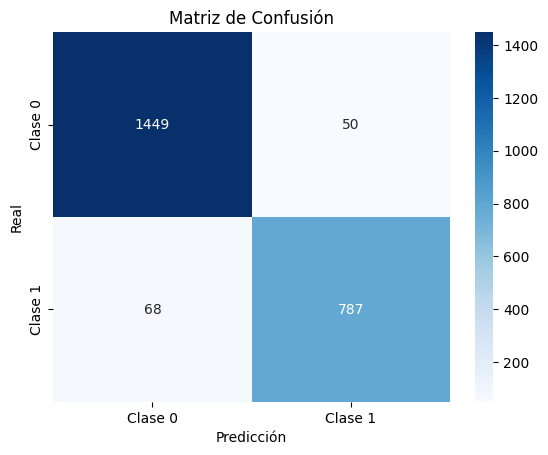

In [12]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### TRANSFORMACIONES

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización, ya que al ser un modelo basado en árboles de decisión, no se ve afectado por las diferencias en las escalas de los valores ni por la falta de normalidad en la distribución de las variables. Los árboles utilizan divisiones basadas en umbrales y no dependen de operaciones algebraicas sensibles a las magnitudes de las variables.

### SELECCIÓN DE VARIABLES

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Al ser un modelo de ensamble de árboles, cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. Las variables irrelevantes tienden a ser ignoradas durante las divisiones, por lo que no contribuyen significativamente al modelo final ni añaden ruido. Además, XGBoost incluye regularización, lo que ayuda a reducir aún más el impacto de características poco informativas.

En nuestro caso eliminamos algunas variables que no aportaban información al modelo para reducir el coste computacional.

### AJUSTE DE HIPERPARÁMETROS

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

En esta estrategia, he definido una cuadrícula (diccionario) con cada hiperparámetro y los posibles valores que pueden tomar. GridSearchCV realiza una búsqueda exhaustiva probando todas las combinaciones posibles de hiperparámetros, evaluando cada modelo mediante validación cruzada. El objetivo es encontrar la combinación que maximice el rendimiento del modelo según el F1-score. Una vez identificado el mejor conjunto de hiperparámetros, procederemos a estudiar el comportamiento del modelo óptimo.

A diferencia de GridSearchCV, RandomizedSearchCV también explora combinaciones de hiperparámetros, pero en lugar de probar todas las combinaciones posibles, selecciona un número fijo de combinaciones al azar. Esto permite explorar un espacio más amplio de hiperparámetros con un menor costo computacional. Al igual que en la búsqueda exhaustiva, las combinaciones son evaluadas mediante validación cruzada, y se selecciona el modelo que optimiza el F1-score.

In [ ]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Cuadrícula de hiperparámetros con y sin ajuste de pesos
    param_grid = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [1, 3],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}

    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,  # Optimiza F1-macro
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

In [24]:
mlflow.set_experiment("Modelos datos de pelas con XGBoost")

<Experiment: artifact_location='file:///c:\\Users\\mattu\\OneDrive\\Documentos\\GitHub\\c2425-R4\\mlruns/103891076235541516', creation_time=1742553912710, experiment_id='103891076235541516', last_update_time=1742553912710, lifecycle_stage='active', name='Modelos datos de pelas con XGBoost', tags={}>

In [ ]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)

-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'scale_pos_weight': np.float64(1.683284457478006), 'subsample': 0.7}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.96      0.97      0.96      1499
        True       0.94      0.93      0.93       855

    accuracy                           0.95      2354
   macro avg       0.95      0.95      0.95      2354
weighted avg       0.95      0.95      0.95      2354



In [ ]:
if mlflow.active_run():
    mlflow.end_run()

# Iniciar un nuevo experimento
with mlflow.start_run(run_name="con k=25 y victorias/derrotas fuera de las medias, prueba con min_child_weight alto"):

    # Guardar modelo en MLflow
    mlflow.xgboost.log_model(best_grid, "modelo_xgboost")
    mlflow.log_param("mejores_parametros", best_params)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
    mlflow.log_metric("f1_macro", f1_val)

    print("Modelo guardado en MLflow")

In [26]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9528462192013594
F1-Score: 0.9348
AUC-ROC: 0.9911
Precisión: 0.9387
Sensibilidad: 0.9310
Log-loss: 0.11485742138995579


Conseguimos una mejora ligera respecto al modelo base.

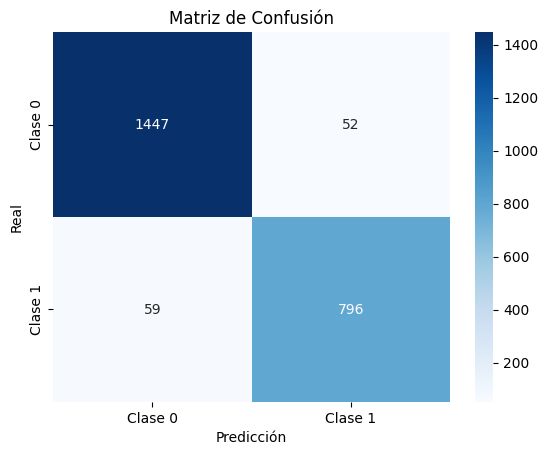

In [28]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [29]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
46    SIG_STR_DIFF    0.090582
45         KD_DIFF    0.080617
41  STR_GROUND_A_x    0.051246
43  STR_GROUND_B_x    0.040553
2             KD_B    0.036425
..             ...         ...
40  STR_CLINCH_B_y    0.003142
30     STR_LEG_A_y    0.003097
3        SIG_STR_A    0.003050
56           WOMEN    0.002987
32     STR_LEG_B_y    0.002944

[77 rows x 2 columns]


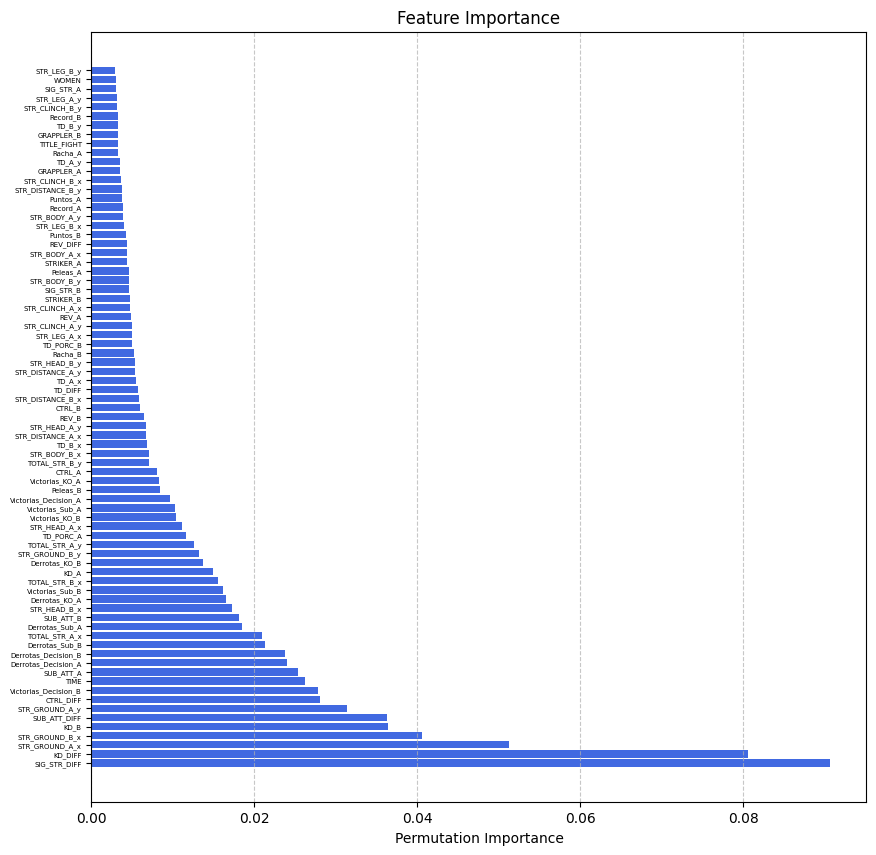

In [30]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Observamos que las variables más importantes son diferencias entre los golpes de los luchadores o diferencia de Knockdowns.

In [31]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 30, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 10, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=5,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return random_search.best_estimator_

In [32]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
best_random = train_xgboost_random(X_train,y_train,X_test,y_test)

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'subsample': np.float64(1.0), 'scale_pos_weight': np.float64(1.683284457478006), 'n_estimators': np.int64(300), 'min_child_weight': np.int64(5), 'max_depth': np.int64(27), 'learning_rate': np.float64(0.1366666666666667), 'gamma': np.float64(0.1), 'colsample_bytree': np.float64(1.0)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.96      0.97      0.96      1499
        True       0.94      0.93      0.94       855

    accuracy                           0.95      2354
   macro avg       0.95      0.95      0.95      2354
weighted avg       0.95      0.95      0.95      2354



In [33]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_test)
y_val_prob = best_random.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)

print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.9541206457094308
F1-Score: 0.9365
AUC-ROC: 0.9905
Precisión: 0.9410
Sensibilidad: 0.9322
Log-loss: 0.12043501679319482


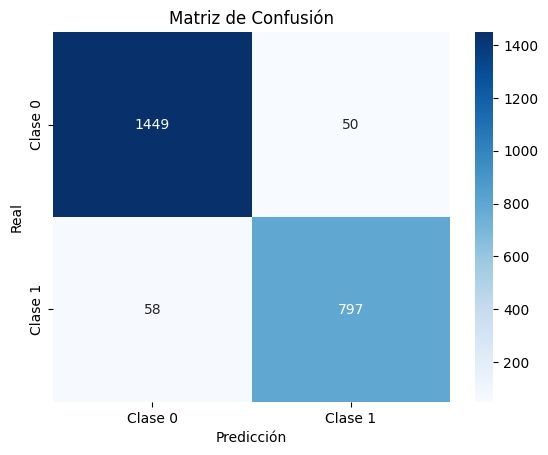

In [35]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [36]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

           Feature  Importance
46    SIG_STR_DIFF    0.142985
45         KD_DIFF    0.094085
2             KD_B    0.054070
50       CTRL_DIFF    0.040576
41  STR_GROUND_A_x    0.037354
..             ...         ...
25    STR_BODY_A_x    0.002210
9            REV_A    0.001461
10           REV_B    0.000000
55     TITLE_FIGHT    0.000000
56           WOMEN    0.000000

[77 rows x 2 columns]


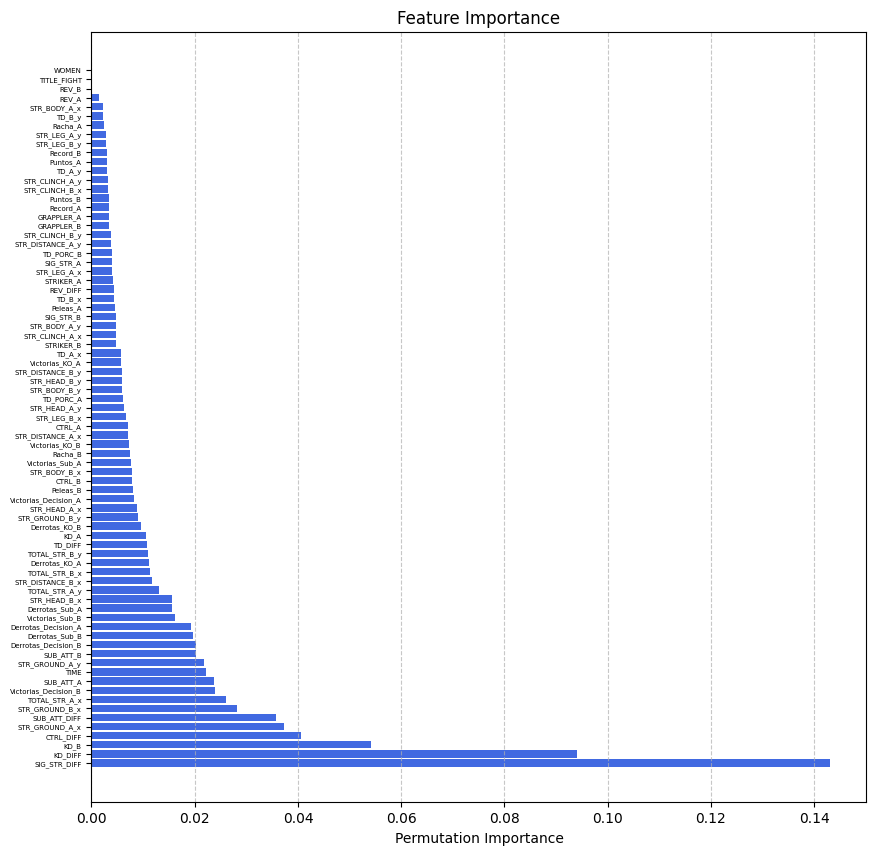

In [37]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Las importancias son las mismas que en el modelo encontrado con el modelo rejilla pero se concentra más importancia en las diferencias.

#### CONCLUSIONES

En este caso RandomizedSearchCV y GridSearchCV llegaron a los mismos resultados, esto significa que la combinación óptima que encuentra la búsqueda en rejilla también se encuentra aleatoriamente. Tras el ajuste de hiperparámetros hemos conseguido mejorar las métricas del modelo base, las cuales ya eran bastante buenas, lo que nos indica que el ajuste de hiperparámetros ha sido correcto.

Como conclusión podemos decir que el modelo funciona bastante bien consiguiendo realizar una gran tasa de aciertos, dando mucha impoortancia a variables que creamos manualmente como las diferencias en ciertos aspectos de la pelea. Uno de los puntos fuertes de este modelo es capturar relaciones no lineales, esto puede hacer que las métricas sean mejores ya que tiene en cuenta las relaciones entre variables